## Anomaly Detection - Sensor Data
Anomaly detection is the task of determining when something has gone astray from the "norm".  Anomaly detection is modeled in an unsupervised / self-supervised manor, as opposed to a supervised learning where there is a one-to-one correspondence between input feature samples and their corresponding output labels.  The presumption is that normal behavior, and hence the quantity of available ’normal’ data, is the norm and that anomalies are the exception to the norm to the point where the modeling of “normalcy” is possible. 

Here, we will train a neural network model to recognize ‘normal' data and then use that model to detect any new data that deviates from the "norm”. This neural network model uses accelerometer sensor data of vibrations from a rotating bearing along each of the three geometrical axes x, y and z to detect when the bearing has gone bad. Three thousand data point samples were taken across all three axes; so we end up with a 9,000 dimensional input space to work within.

<table>
<td>
<img src="images/sensor_data.png" style="width:250;height:300px;">
</td>
</table>

In [1]:
# import libraries
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from  sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint, TensorBoard
import pickle

Using TensorFlow backend.


In [2]:
# load the healthy & broken bearing data
with open('watsoniotp.healthy.phase_aligned.pickle', 'rb') as f1:
    u = pickle._Unpickler(f1)
    u.encoding = 'latin1'
    healthy = u.load()
    print("Healthy data shape:", healthy.shape)
with open('watsoniotp.broken.phase_aligned.pickle', 'rb') as f2:
    u = pickle._Unpickler(f2)
    u.encoding = 'latin1'
    broken = u.load()
    print("Broken data shape:", broken.shape)

Healthy data shape: (3000, 3)
Broken data shape: (3000, 3)


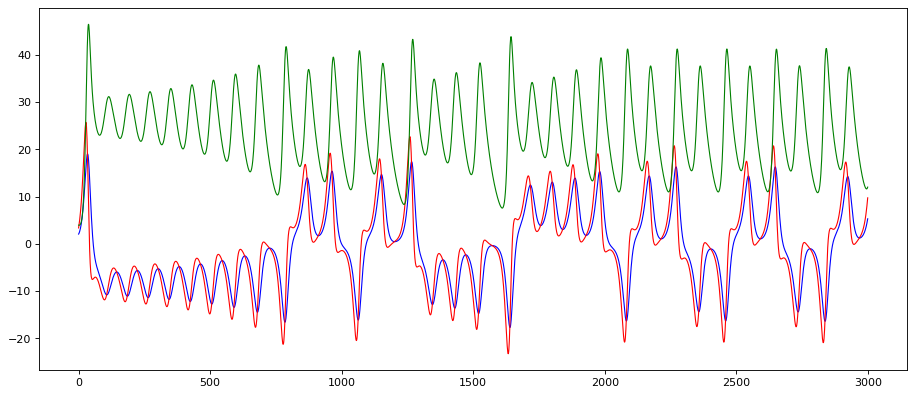

In [3]:
# inspect the healthy data
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy)
ax.plot(range(0,size), healthy[:,0], color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), healthy[:,1], color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy[:,2], color='green', animated = True, linewidth=1)
plt.show()

Looking at the healthy data, we notice that while this system oscillates between two semi-stable states, it is hard to identify any regular patterns.

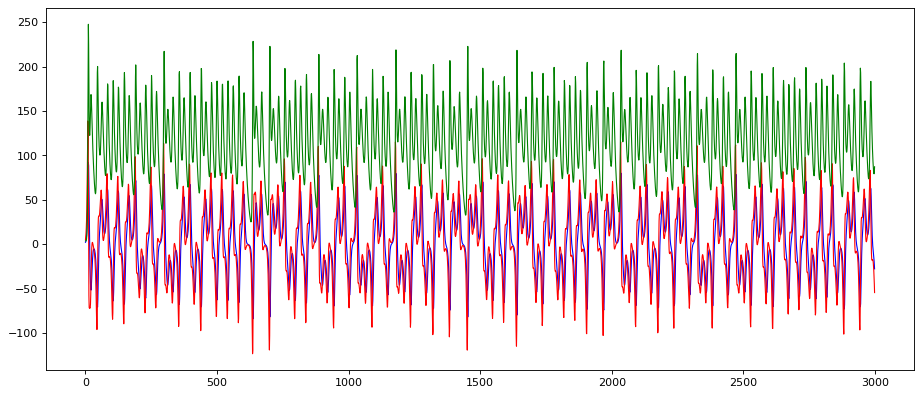

In [4]:
# inspect the broken bearing data
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(broken)
ax.plot(range(0,size), broken[:,0], color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), broken[:,1], color='red', animated = True, linewidth=1)
ax.plot(range(0,size), broken[:,2], color='green', animated = True, linewidth=1)
plt.show()

The broken data shows much more energy in the system. The peaks are exceeding 200 in contrast to the healthy state which never went over 50. Also, it appears that the frequency content of the second signal is higher.

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [5]:
# transforming data from the time domain to the frequency domain
healthy_fft = np.fft.fft(healthy)
broken_fft = np.fft.fft(broken)

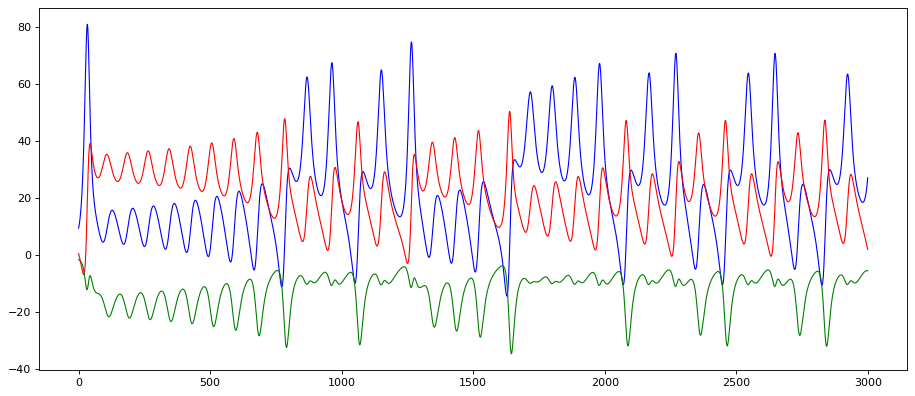

In [6]:
# frequencies of the healthy signal
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_fft)
ax.plot(range(0,size), healthy_fft[:,0].real, color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_fft[:,1].imag, color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_fft[:,2].real, color='green', animated = True, linewidth=1)

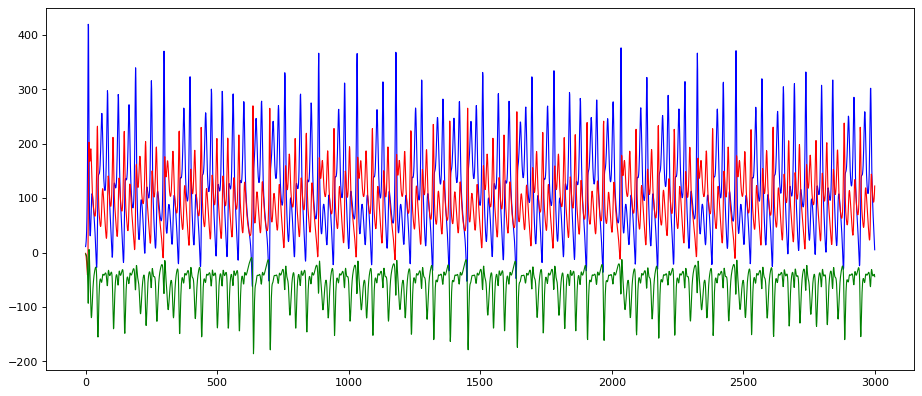

In [7]:
# frequencies of the broken data signal
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(broken_fft)
ax.plot(range(0,size), broken_fft[:,0].real, color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), broken_fft[:,1].imag, color='red', animated = True, linewidth=1)
ax.plot(range(0,size), broken_fft[:,2].real, color='green', animated = True, linewidth=1)

<b>Note</b>: We are plotting the imaginary part of the red dimension to see three lines because two dimensions on this dataset are completely overlapping in frequency and the real part is zero. Remember, the way FFT (fast Fournier transform) works is retuning the sine components in the real domain and the cosine components in the imaginary domain. Just a hack mathematicians use to return a tuple of vectors.

In [8]:
# function to scale the data
def scaleData(data):
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(data)

In [9]:
# normalize the data
healthy_scaled = scaleData(healthy)
broken_scaled = scaleData(broken)

In [10]:
# reshape data for an LSTM network [samples, timesteps, features]
samples = healthy_scaled.shape[0]
timesteps = 10
features = healthy_scaled.shape[1]
X = healthy_scaled.reshape(int(samples/timesteps), timesteps, features)
print("Healthy data shape:", X.shape)
X_broken = broken_scaled.reshape(int(samples/timesteps), timesteps, features)
print("Broken data shape:", X_broken.shape)

Healthy data shape: (300, 10, 3)
Broken data shape: (300, 10, 3)


This way instead of 3,000 samples per dimension (per vibration axis) we have 300 batches of length 10. What we want to do is given the last 10 time steps of the signal predict the future 10.

In [11]:
# define the LSTM model
def lstm_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(50, return_sequences=True)(inputs)
    L2 = LSTM(50, return_sequences=True)(L1)
    L3 = LSTM(50, return_sequences=True)(L2)
    L4 = LSTM(50, return_sequences=True)(L3)
    L5 = LSTM(50, return_sequences=True)(L4)
    L6 = LSTM(50, return_sequences=True)(L5)
    L7 = LSTM(50, return_sequences=True)(L6)
    L8 = LSTM(50, return_sequences=True)(L7)
    L9 = LSTM(50, return_sequences=True)(L8)
    L10 = LSTM(50, return_sequences=True)(L9)
    L11 = LSTM(50, return_sequences=True)(L10)
    output = Dense(3)(L11)
    model = Model(inputs=inputs, outputs=output)
    return model    

In [12]:
# create the LSTM model
model = lstm_model(X)
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            10800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 50)            20200     
__________

In [13]:
# create training function
nb_epochs = 50
batch_size = 72
def train(data):
    history = model.fit(data, data, epochs=nb_epochs, batch_size=batch_size, shuffle=False, verbose=0).history
    return history['loss']

In [14]:
# train model on healthy data
trials = 20
losses = []
for i in range(trials):
    output = train(X)
    losses.extend(output)

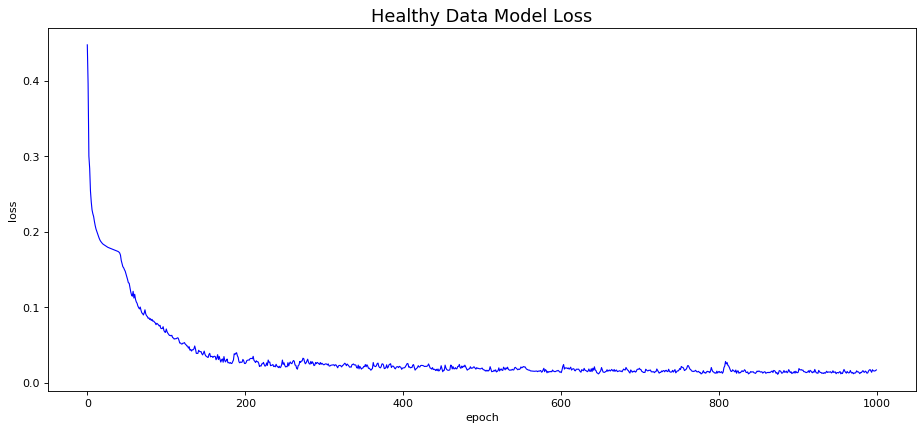

In [15]:
# plot the healthy model losses
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.set_title('Healthy Data Model Loss', fontsize=16)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.plot(range(0,len(losses)), losses, color='blue', animated = True, linewidth=1)

In [16]:
# insert the broken data
brk_out = train(X_broken)
losses.extend(brk_out)

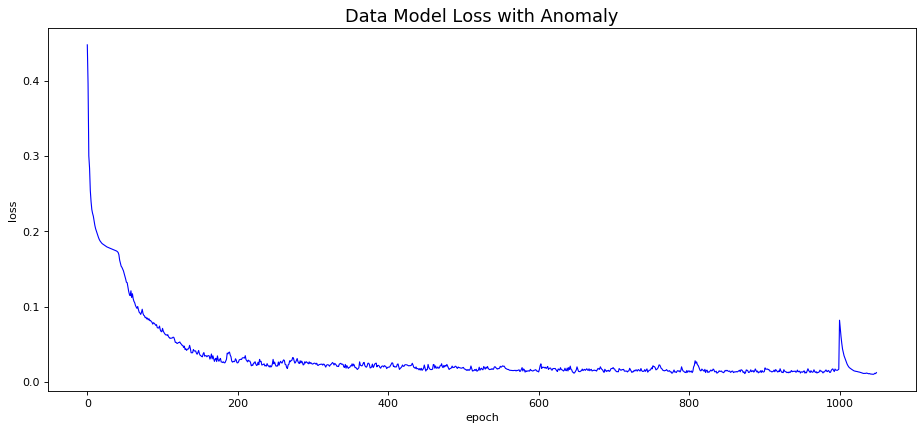

In [17]:
# plot the updated model losses
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.set_title('Data Model Loss with Anomaly', fontsize=16)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.plot(range(0,len(losses)), losses, color='blue', animated = True, linewidth=1)

The anomaly is detected via the sudden rise, spike, in the loss values from the trained model.